# Import Libraries 

In [101]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np 
import seaborn as sns

# Load Dataset

In [102]:
dataset = pd.read_csv("Malware_Dataset.csv")

In [103]:
dataset.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


# Prepare Dataset

In [104]:
## Drop Category, not needed. 

In [105]:
df = dataset.drop(['Category'], axis=1)

In [106]:
## make class 0 and 1 instead of malware and benign 
## malware = 1
## Bennign = 0 


In [107]:
df['Class'] = df['Class'].replace(['Malware', 'Benign'], [1, 0]) 

In [108]:
data = pd.DataFrame()

In [109]:
top_10_features_correlation_analysis = pd.DataFrame()

In [110]:
## Creating a dataset with only the top 10 features chosen by corelation analysis, 
## Feature importance analysis was done in the "Data visualizations" the features were copied over, because it is more efficient
## than running correlation analysis on each notebo

In [111]:
top_ten_features = ['psxview.not_in_ethread_pool_false_avg', 'psxview.not_in_deskthrd', 'psxview.not_in_session_false_avg',
                  'psxview.not_in_csrss_handles_false_avg', 'malfind.protection', 'malfind.ninjections', 'malfind.uniqueInjections', 
                  'malfind.commitCharge','psxview.not_in_deskthrd_false_avg','pslist.nppid', 'Class']

In [112]:
## creating new dataset using a for loop that iterates through the features of the original dataset, find the ones that 
## match in array of features and then copy the top 10 features to the new dataset. 

for feature in  top_ten_features: 
    top_10_features_correlation_analysis[feature] = df[feature]

In [113]:
top_10_features_correlation_analysis.head()

,psxview.not_in_ethread_pool_false_avg,psxview.not_in_deskthrd,psxview.not_in_session_false_avg,psxview.not_in_csrss_handles_false_avg,malfind.protection,malfind.ninjections,malfind.uniqueInjections,malfind.commitCharge,psxview.not_in_deskthrd_false_avg,pslist.nppid,Class
0,0.063830,9,0.085106,0.148936,30,5,1.250000,21,0.191489,17,0
1,0.000000,6,0.042553,0.085106,72,12,1.714286,77,0.127660,19,0
2,0.000000,5,0.050000,0.100000,30,5,1.250000,6,0.125000,14,0
3,0.000000,6,0.062500,0.125000,12,2,1.000000,2,0.187500,13,0
4,0.086957,10,0.130435,0.173913,72,12,2.000000,77,0.217391,16,0


In [114]:
malware_samples_indices = top_10_features_correlation_analysis[top_10_features_correlation_analysis['Class'] == 1].index
num_rows_to_delete = int(0.8 * len(malware_samples_indices))
rows_to_delete = np.random.choice(malware_samples_indices, size=num_rows_to_delete, replace=False)



In [115]:
top_10_features_correlation_analysis = top_10_features_correlation_analysis.drop(rows_to_delete)

In [116]:
print(top_10_features_correlation_analysis['Class'].value_counts())

0    29298
1     5860
Name: Class, dtype: int64


# Split Dataset into Training and Test Set

In [117]:
##Split dataset into X and Y values
## Because these models are unsupervised, labels are not needed for training 
# only used for evaluation at the end.

In [118]:
X = top_10_features_correlation_analysis.iloc[:,:-1].values
y = top_10_features_correlation_analysis.iloc[:,-1].values

In [119]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2, random_state=42)

In [143]:
accuracies = []
precisions = []
recalls = []
f1_scores = [] 

# Train and Evaluate Isolation Forest Model 

In [120]:
## isolation forest 
Isolation_Forest_model=IsolationForest(max_samples= 100, n_estimators= 200, contamination=0.2, bootstrap = True)
Isolation_Forest_model.fit(Xtrain)

IsolationForest(bootstrap=True, contamination=0.2, max_samples=100,
                n_estimators=200)

In [121]:
predictions = Isolation_Forest_model.predict(Xtest)
print(predictions)


[1 1 1 ... 1 1 1]


In [122]:
print(pd.value_counts(predictions))

 1    5634
-1    1398
dtype: int64


In [123]:
## map the predictions to 0 and 1 from -1 and 1
## map anomalies to 1 and normal instances to 0

In [124]:
predictions[predictions== 1] = 0
predictions[predictions== -1] = 1

In [125]:
print(pd.value_counts(predictions))

0    5634
1    1398
dtype: int64


In [126]:
## start evaluation. 
## Classification Report
## confusion Matrix 

In [127]:
Isolation_forest_classification_report = classification_report(predictions, ytest)
print(Isolation_forest_classification_report)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      5634
           1       0.21      0.18      0.19      1398

    accuracy                           0.71      7032
   macro avg       0.51      0.51      0.51      7032
weighted avg       0.69      0.71      0.69      7032



<Axes: >

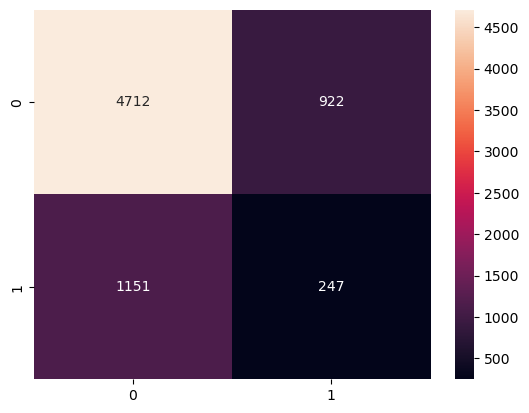

In [128]:
Isolation_forest_confusion_matrix = confusion_matrix(predictions, ytest)
sns.heatmap(Isolation_forest_confusion_matrix, fmt='2', annot=True)

In [145]:
Isolation_forest_accuracy = accuracy_score(predictions, ytest)
Isolation_forest_precision = precision_score(predictions, ytest)
Isolation_forest_recall = recall_score(predictions, ytest)
Isolation_forest_f1_score = f1_score(predictions, ytest)

print(Isolation_forest_accuracy)
print(Isolation_forest_precision)
print(Isolation_forest_recall)
print(Isolation_forest_f1_score)

0.7052047781569966
0.21129170230966637
0.17668097281831188
0.19244253992987922


In [146]:
accuracies.append(Isolation_forest_accuracy)
precisions.append(Isolation_forest_precision)
recalls.append(Isolation_forest_recall)
f1_scores.append(Isolation_forest_f1_score)

# Train and test Local Outlier Factor Model 

In [130]:
## Local Outlier Factor 
Local_outlier_factor = LocalOutlierFactor(n_neighbors = 100, algorithm='auto', contamination=0.2, novelty=True)
Local_outlier_factor.fit(Xtrain)


LocalOutlierFactor(contamination=0.2, n_neighbors=100, novelty=True)

In [131]:
LOF_predictions = Local_outlier_factor.predict(Xtest)

In [132]:
LOF_predictions[LOF_predictions== 1] = 0
LOF_predictions[LOF_predictions== -1] = 1

print(pd.value_counts(LOF_predictions))

0    5626
1    1406
dtype: int64


In [133]:
LOF_classification_report = classification_report(LOF_predictions, ytest)
print(LOF_classification_report)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      5626
           1       0.26      0.22      0.24      1406

    accuracy                           0.72      7032
   macro avg       0.54      0.53      0.53      7032
weighted avg       0.70      0.72      0.71      7032



<Axes: >

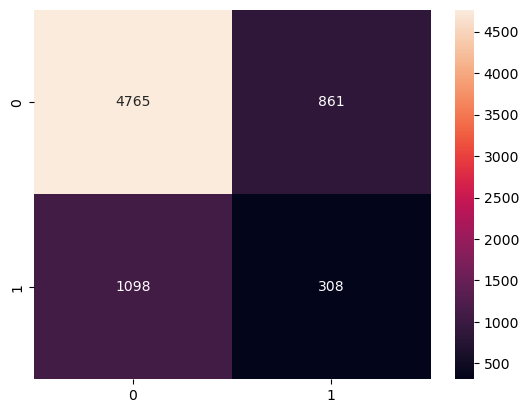

In [134]:
LOF_confusion_matrix = confusion_matrix(LOF_predictions, ytest)
sns.heatmap(LOF_confusion_matrix, fmt='2', annot=True)

In [147]:
LOF_accuracy = accuracy_score(LOF_predictions, ytest)
LOF_precision = precision_score(LOF_predictions, ytest)
LOF_recall = recall_score(LOF_predictions, ytest)
LOF_f1_score = f1_score(LOF_predictions, ytest)

print(LOF_accuracy)
print(LOF_precision)
print(LOF_recall)
print(LOF_f1_score)

0.7214163822525598
0.2634730538922156
0.21906116642958748
0.2392233009708738


In [148]:
accuracies.append(LOF_accuracy)
precisions.append(LOF_precision)
recalls.append(LOF_recall)
f1_scores.append(LOF_f1_score)

# Train and Evaluate One Class SVM Model

In [137]:
one_class_svm = OneClassSVM()
one_class_svm.fit(Xtrain)


OneClassSVM()

In [138]:
one_class_svm_predictions=one_class_svm.predict(Xtest)

In [139]:
one_class_svm_predictions[one_class_svm_predictions== 1] = 0
one_class_svm_predictions[one_class_svm_predictions== -1] = 1

print(pd.value_counts(one_class_svm_predictions))

0    3549
1    3483
dtype: int64


In [140]:
SVM_classification_report = classification_report(one_class_svm_predictions, ytest)
print(SVM_classification_report)

              precision    recall  f1-score   support

           0       0.59      0.97      0.73      3549
           1       0.92      0.31      0.46      3483

    accuracy                           0.64      7032
   macro avg       0.75      0.64      0.60      7032
weighted avg       0.75      0.64      0.60      7032



<Axes: >

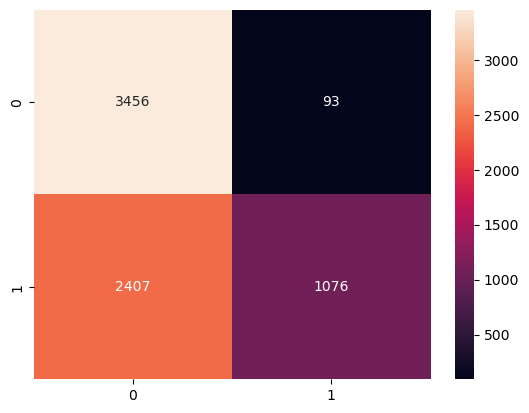

In [141]:
SVM_confusion_matrix = confusion_matrix(one_class_svm_predictions, ytest)
sns.heatmap(SVM_confusion_matrix, fmt='2', annot=True)

In [149]:
OC_SVM_accuracy = accuracy_score(one_class_svm_predictions, ytest)
OC_SVM_precision = precision_score(one_class_svm_predictions, ytest)
OC_SVM_recall = recall_score(one_class_svm_predictions, ytest)
OC_SVM_f1_score = f1_score(one_class_svm_predictions, ytest)

print(OC_SVM_accuracy)
print(OC_SVM_precision)
print(OC_SVM_recall)
print(OC_SVM_f1_score)

0.6444823663253697
0.9204448246364414
0.30892908412288256
0.4625967325881341


In [150]:
accuracies.append(OC_SVM_accuracy)
precisions.append(OC_SVM_precision)
recalls.append(OC_SVM_recall)
f1_scores.append(OC_SVM_f1_score)

# Evaluation Table

In [ ]:
## All models have been trained and evaluated, now the final evaluation table will be generated

In [151]:
Evaluation_Table = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])


Evaluation_Table = pd.concat([Evaluation_Table, pd.DataFrame({
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1-Score": f1_scores
})], ignore_index=True)

Evaluation_Table.index = ['Isolation Forest', 'Local Outlier Factor', 'One Class SVM']
Evaluation_Table.index.names = ['Models']

In [152]:
Evaluation_Table

,Accuracy,Precision,Recall,F1-Score
Models,,,,
Isolation Forest,0.705205,0.211292,0.176681,0.192443
Local Outlier Factor,0.721416,0.263473,0.219061,0.239223
One Class SVM,0.644482,0.920445,0.308929,0.462597
